In [1]:
import torch
import torch.nn as nn
import torchvision
from model_file import model
from vce_dataloader import getBinaryDataLoader, getAllDataLoader, visualize_batch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


In [2]:
allDL_train = getAllDataLoader(image_size=(224,224), 
                               path_to_dataset="/kaggle/input/vce-dataset/training", batch_size=32)
allDL_val = getAllDataLoader(image_size=(224,224), 
                               path_to_dataset="/kaggle/input/vce-dataset/validation", batch_size=32)

In [3]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [4]:
checkpt_path = kagglehub.model_download('bhuvaneshsingla/binaryvce/PyTorch/1to20/1', path='Binary20.pt')
checkpoint = torch.load(checkpt_path)

/tmp/ipykernel_23/2672714848.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpt_path)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [7]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [9]:
model.module.fc = nn.Linear(num_ftrs, 10)

In [10]:
model = model.to(device)

In [11]:
num_epochs = 10

In [12]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    
    for inputs, labels in allDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in allDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/10]
Train Loss: 0.8381, Train Accuracy: 0.7139
Validation Loss: 0.7707, Validation Accuracy: 0.7455
Epoch [2/10]
Train Loss: 0.3858, Train Accuracy: 0.8767
Validation Loss: 0.9417, Validation Accuracy: 0.7192
Epoch [3/10]
Train Loss: 0.2494, Train Accuracy: 0.9247
Validation Loss: 1.0415, Validation Accuracy: 0.7259
Epoch [4/10]
Train Loss: 0.1882, Train Accuracy: 0.9460
Validation Loss: 1.0354, Validation Accuracy: 0.7286
Epoch [5/10]
Train Loss: 0.1667, Train Accuracy: 0.9535
Validation Loss: 1.1733, Validation Accuracy: 0.7070
Epoch [6/10]
Train Loss: 0.1439, Train Accuracy: 0.9593
Validation Loss: 1.0857, Validation Accuracy: 0.7292
Epoch [7/10]
Train Loss: 0.1282, Train Accuracy: 0.9638
Validation Loss: 1.1063, Validation Accuracy: 0.7292
Epoch [8/10]
Train Loss: 0.1221, Train Accuracy: 0.9651
Validation Loss: 1.3414, Validation Accuracy: 0.6909
Epoch [9/10]
Train Loss: 0.1103, Train Accuracy: 0.9685
Validation Loss: 1.0926, Validation Accuracy: 0.7356
Epoch [10/10]
Train

In [13]:
PATH = "All10.pt"
torch.save({
            'epoch': num_epochs-1,
            'model_state_dict': model.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [14]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)  # Move images to the same device as model
            labels = labels.to(device)  # Move labels to the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    return np.array(all_preds), np.array(all_labels)

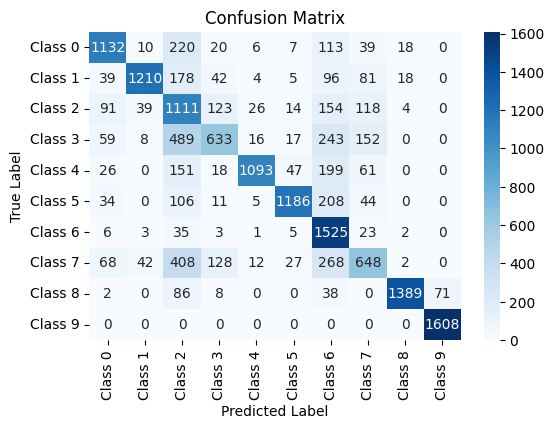

In [15]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, allDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(10)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()